In [6]:
import torch
from torch import nn
from torch.nn import functional as F
# from collections import OrderedDict

In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors

def plotCorrMatrix(qDotK):


  # map with blue and green colors
  colors_list = ['#FF5733', '#FFC300']
  cmap = colors.ListedColormap(colors_list)

  # Plot the heatmap with custom colors and annotations
  plt.imshow(corr_matrix, cmap=cmap, vmin=0\
            , vmax=1, extent=[0, 5, 0, 5])
  for i in range(5):
      for j in range(5):
          plt.annotate(str(round(qDotK.values[i][j], 2)),\
                      xy=(j+0.25, i+0.7),
                      ha='center', va='center', color='white')

  # Add colorbar
  cbar = plt.colorbar(ticks=[0, 0.5, 1])
  cbar.ax.set_yticklabels(['Low', 'Medium', 'High'])

  # Set plot title and axis labels
  plt.title("Correlation Matrix Of The Dataset")
  plt.xlabel("Features")
  plt.ylabel("Features")

  # Set tick labels
  plt.xticks(range(len(corr_matrix.columns)),\
            corr_matrix.columns, rotation=90)
  plt.yticks(range(len(corr_matrix.columns)),
            corr_matrix.columns)

  # Display the plot
  plt.show()



In [9]:
qDotK =  np.random.randint(low=1,
                         high=100,
                         size=(5, 5))

In [63]:
import os
import requests
import torch
from torch import nn
from torch.nn import functional as F
from google.colab import drive
drive.mount('/content/drive')

from datetime import datetime

def saveModel(model, pathReq = None, colab = True):

  fileName = 'model_' + str(datetime.now()).replace('-','').replace(':','').replace(' ','')[:14] + '.pth'

  if colab and pathReq is None:
    filePath = '/content/drive/MyDrive/myRepository/savedModels/' + fileName
  else:
    filePath = os.getcwd() + '/' + fileName

  torch.save(model.state_dict(), filePath)

  print('model saved in {}'.format(filePath))

def getRawData():
  data_url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
  data = requests.get(data_url).text

  print(f"length of raw dataset: {len(data):,}")

  # get all the unique characters that occur in this text
  possibleTokens = sorted(list(set(data)))

  return data, possibleTokens, len(possibleTokens)

def myDataLoader(dataSet, batchSize, blockSize):
  batch = []
  toPredict = []
  i = 0
  block = 0
  for b in range(0, len(dataSet)//blockSize):
    batch.append(dataSet[block : (block + blockSize)])
    toPredict.append(dataSet[block + 1 : (block + 1 + blockSize)]) #adding next letter for the one to predict
    block += blockSize
    if (b+1) % batchSize == 0:
      yield batch, toPredict
      batch = []
      toPredict = []

#====
wordToTensor = lambda sInput, tokenMapping: [tokenMapping[letter] for letter in sInput] # to get numerical tensor to feed into nn.Embedding function (each letter has it's index)
tensorToWord = lambda sIndexes, tokenMapping: [list(tokenMapping.keys())[i.item()] for i in sIndexes]

class LayerNorm(nn.Module):
    """ LayerNorm but with an optional bias. PyTorch doesn't support simply bias=False """

    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, input):
        return F.layer_norm(input,self.weight.shape, self.weight, self.bias, 1e-5)

#trying to make it more modular so put attention as a separate class on it's own
class multiHeadAttn(nn.Module):
  def __init__(self, dFf, d_k, n_heads, vocabSize, blockSize, processor = 'cpu'):
    super().__init__()
    self.d_k = d_k
    self.n_heads = n_heads
    self.dModel = d_k  #512 in the paper
    self.dFf = dFf # 2048 in the paper
    self.processor = processor
    self.encodeQ = nn.Linear(d_k, d_k).to(device = processor) #to include in backpropogation graph you need to use "self."
    self.encodeK = nn.Linear(d_k, d_k).to(device = processor)
    self.encodeV = nn.Linear(d_k, d_k).to(device = processor)

  def plotCorrMatrix(self, qDotK, letterIndices):

    qDotK = qDotK.detach().numpy()
    # Plot the heatmap with custom colors and annotations
    plt.imshow(qDotK, cmap='autumn', extent=[0, qDotK.shape[1], 0, qDotK.shape[1]])

    # for i in range(qDotK.shape[0]):
    #     for j in range(qDotK.shape[1]):
    #         plt.annotate(str(round(qDotK[i][j], 2)),xy=(j+0.1, i+0.1),ha='center', va='center', color='blue')

    vocab = ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R',
            'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

    tokenMapping = {k:v for v, k in enumerate(vocab)} #make dict where value is index of token and key is token itself
    # Set plot title and axis labels
    plt.title('heatmap')
    # print(letterIndices.shape, letterIndices)
    qLetters = tensorToWord(letterIndices.squeeze(0), tokenMapping)#['a','b','c','d','e']
    kLetters = tensorToWord(letterIndices.squeeze(0), tokenMapping) #['a','b','c','d','e']

    # Set tick labels
    plt.xticks(range(qDotK.shape[1]),qLetters, rotation=90)
    plt.yticks(range(qDotK.shape[1]), kLetters)

    # Display the plot
    plt.show()

  def forward(self, qkv, letterIndices = None):
    B, T, C = qkv.size()

    Q = self.encodeQ(qkv).to(device = self.processor)#same process for all 3 (see paper multi-head attn figure)
    K = self.encodeK(qkv).to(device = self.processor)
    V = self.encodeV(qkv).to(device = self.processor)

    Q = Q.view(B, T, self.n_heads, C // self.n_heads).transpose(1,2) #B, heads, T, C
    K = K.view(B, T, self.n_heads, C // self.n_heads).transpose(1,2) #B, heads, T, C
    V = V.view(B, T, self.n_heads, C // self.n_heads).transpose(1,2) #B, heads, T, C

    #see (Q*K.T)/sqrt(d^k) in paper (this is self-attention where the embeddings are self-multiplied and trained separately
    # for example, 3 x 32 becomes 3 x 3 self score where one element will eventually figure out it's relation to members of neighbouring timesteps
    # maybe we can make a heat map for this and see how it progresses over time
    QkDotProduct = torch.matmul(Q,K.transpose(-2,-1))/torch.sqrt(torch.Tensor([self.d_k]).to(device = self.processor))# B, T, T
    #each row is 1 timestep more
    if letterIndices is not None:
      self.plotCorrMatrix(QkDotProduct[0,1], letterIndices)#just taking first batch as trial


    successiveTokensMask = torch.tril(torch.ones(T,T)).view(1,1,T,T).to(device = self.processor)
    # setting everything ahead of the mask to infinity to make sure labels aren't included in training data
    QkDotProduct = QkDotProduct.masked_fill(successiveTokensMask[:,:,:T,:T] == 0, float('-inf'))
    #gives scores per query with respect to the key it matches (softmax on final dim with shape = B, T, C)
    dotProdAttn = torch.softmax(QkDotProduct, dim=-1)
    #multiply attn weights with "V". The softmax after the mask forces the division of attention based on how many words there are in the sample
    headOutput = torch.matmul(dotProdAttn, V)
    headOutput = headOutput.transpose(1,2).contiguous().view(B,T,C)

    return headOutput

class DecoderBlock(nn.Module):
  def __init__(self, dFf, d_k, n_heads, vocabSize, blockSize, processor = 'cpu'):
    super().__init__()
    self.selfAttn = multiHeadAttn(dFf, d_k, n_heads, vocabSize, blockSize, processor)

    self.FFN = nn.Sequential(
                nn.Linear(d_k, dFf).to(device = processor),
                nn.ReLU().to(device = processor),
                nn.Linear(dFf, d_k).to(device = processor)
        ).to(device = processor)

    self.ln = LayerNorm(d_k, False).to(device = processor)


  def forward(self, qkv, indices):
    x = self.selfAttn(qkv, indices)
    x = x + self.ln(x)
    x = self.FFN(x)
    x = x + self.ln(x)
    return x

class theTransformer(nn.Module):
  def __init__(self, attnLayers, dFf, d_k, parallelHeads, vocabSize, blockSize, processor = 'cpu'):
    super().__init__()
    self.d_k = d_k
    self.embedTok = nn.Embedding(vocabSize, d_k).to(device = processor) #vocabSize, channelsWanted
    self.embedPos = nn.Embedding(blockSize, d_k).to(device = processor) #vocabSize, channelsWanted
    self.decoder = DecoderBlock(dFf, d_k, parallelHeads, vocabSize, blockSize, processor) #instantiate decoder block
    self.layers = nn.ModuleList([self.decoder for decoders in range(attnLayers)]).to(device = processor)
    self.LinearFinal = nn.Linear(self.d_k, vocabSize).to(device = processor)
    self.processor = processor

  def forward(self, batchData, target, pos, training = True, softmax = True):
    x = self.embedTok(batchData) + self.embedPos(pos)
    for l in self.layers: # running through all the decoder layers we wanted
      x = l(x, batchData)
    logits = self.LinearFinal(x) # get per token logits for later backprop
    B,T,C = logits.shape

    if softmax:
      logits = torch.softmax(logits, dim = 1) # get per token probabilities for later backprop

      #the cross_entropy function has dimension requirement which we solve by making pred dim = (B*T, C) and target dim = (B*T) (C is classes not channels, while target has ground truth so only 1 class)
      pred, target = logits.view(B*T, C), F.one_hot(target.long().view(B*T), num_classes = 65).type(torch.FloatTensor).to(device = self.processor)#if we want to use softmax (need to convert one-hot encoding to float so it can actually do cross entropy operations with pred which is float)
    else:
      pred, target = logits.view(B*T, C), target.long().view(B*T)

    if training:
      #remember, targets are offset by one token to the future, so this loss function pushes the model towards predicting the next token using the encoded information
      loss = F.cross_entropy(pred, target).to(device = self.processor)
    else:
      logits = logits[:, [-1],:]
      loss = 0

    return loss, logits


def train(data, tokenMapping, lDff, lD_k, lNLayers, lParallelHeads, lVocabSize, lBatchSize, lBlockSize, lPos, lEpochs, softmax, processor = 'cpu'):

  numericRepresentation = wordToTensor(data,tokenMapping) #changing character to index-based integer

  finalTransformer = theTransformer(lNLayers, lDff, lD_k, lParallelHeads, lVocabSize, lBlockSize, processor)

  finalTransformer.to(device = processor)

  optimizer = torch.optim.Adam(finalTransformer.parameters(), lr=gLearningRate) #make optimizer for the decoder block

  i = 0

  for e in range(lEpochs):
    for batchData, forwardPrediction in myDataLoader(numericRepresentation, lBatchSize, lBlockSize):
      optimizer.zero_grad()
      loss, outputLogits = finalTransformer(torch.IntTensor(batchData).to(device = processor), torch.LongTensor(forwardPrediction).to(device = processor) , lPos.to(device = processor), softmax=softmax)
      loss.backward()
      optimizer.step()

      i+=1

      if i % 1000 == 0:
        print(e, loss)

      if i % 10000 == 0:
        saveModel(finalTransformer)


#====================================


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [64]:
data, gTokens, gVocabSize = getRawData()

gChannelsWanted = 128 # hopefully a good enough embdding to learn required features
gD_k = gChannelsWanted
gDff = 512 #for intermediary feedforward process
gParallelHeads = 8 #for batch processing
gNLayers = 4 #how many blocks to use to make deeper network
gBatchSize = 5
gBlockSize = 10
gLearningRate = 1e-5
gPos = torch.arange(0, gBlockSize, dtype=torch.long) #to make a kind of positional embedding
gEpochs = 5
vocab = gTokens # !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
tokenMapping = {k:v for v, k in enumerate(vocab)} #make dict where value is index of token and key is token itself
softmax = True

length of raw dataset: 1,115,394


In [65]:
def loadModel(model, pathReq):
  model.load_state_dict(torch.load(pathReq))
  model.eval()
  return model

path = '/content/drive/MyDrive/myRepository/savedModels/model_20230822020436.pth'
finalTransformer = theTransformer(gNLayers, gDff, gD_k, gParallelHeads, gVocabSize, gBlockSize)
finalTransformer = loadModel(finalTransformer, path)

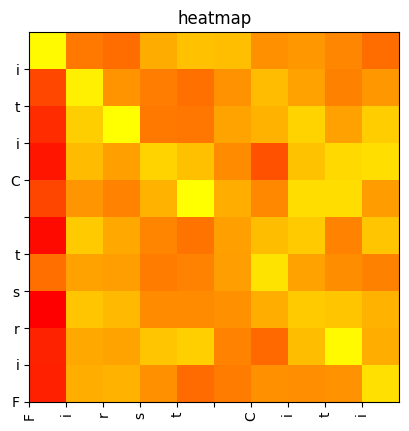

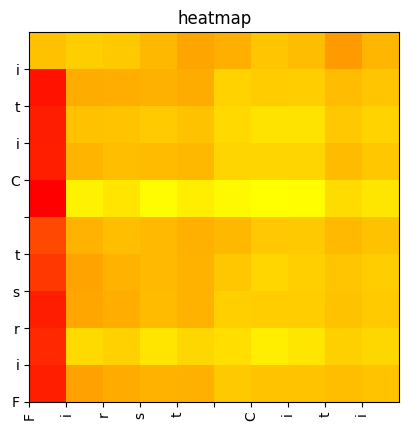

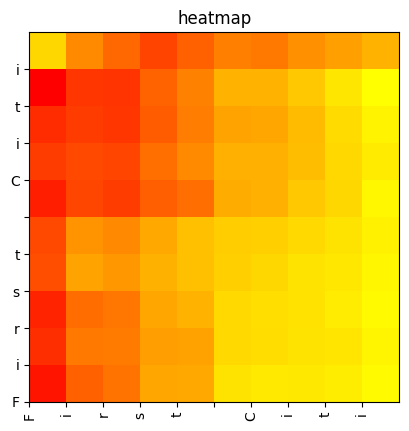

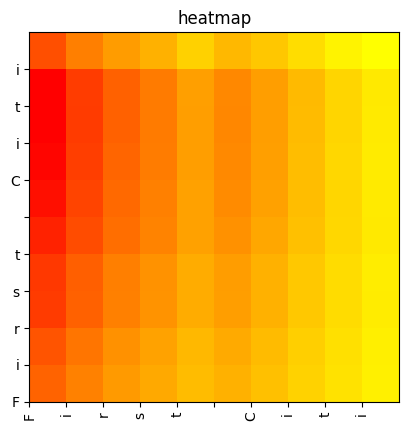

In [66]:
numericRepresentation = wordToTensor(data,tokenMapping) #changing character to index-based integer

outString = ''
i = 0
inferenceData = numericRepresentation[:10] #get next batch
gPos = torch.arange(0,10, dtype=torch.long) #adding pos embedding
loss, outputLogits = finalTransformer(torch.LongTensor(inferenceData).unsqueeze(0), torch.LongTensor(inferenceData).unsqueeze(0) , gPos, training=False)

In [38]:
vocab = gTokens # !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
vocab

['\n',
 ' ',
 '!',
 '$',
 '&',
 "'",
 ',',
 '-',
 '.',
 '3',
 ':',
 ';',
 '?',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [ ]:
train(data, tokenMapping, gDff, gD_k, gNLayers, gParallelHeads, gVocabSize, gBatchSize, gBlockSize, gPos, gEpochs, softmax, 'cuda')

0 tensor(4.1180, device='cuda:0', grad_fn=<DivBackward1>)
0 tensor(4.0626, device='cuda:0', grad_fn=<DivBackward1>)
0 tensor(4.0348, device='cuda:0', grad_fn=<DivBackward1>)
0 tensor(3.9985, device='cuda:0', grad_fn=<DivBackward1>)
0 tensor(4.0097, device='cuda:0', grad_fn=<DivBackward1>)
0 tensor(4.0239, device='cuda:0', grad_fn=<DivBackward1>)
0 tensor(3.9458, device='cuda:0', grad_fn=<DivBackward1>)
0 tensor(3.9130, device='cuda:0', grad_fn=<DivBackward1>)


In [ ]:
def loadModel(model, pathReq):
  model.load_state_dict(torch.load(pathReq))
  model.eval()
  return model

path = '/content/drive/MyDrive/myRepository/savedModels/model_20230822000041.pth'
finalTransformer = theTransformer(gNLayers, gDff, gD_k, gParallelHeads, gVocabSize, gBlockSize)
finalTransformer = loadModel(finalTransformer, path)

In [ ]:
def outputWords(indices, tokenMapping):
  s=''
  for els in indices:
    for ss in tensorToWord(els, tokenMapping):
      s += ss
  return s

numericRepresentation = wordToTensor(data,tokenMapping) #changing character to index-based integer

def generateScript(blockSize, outputSizeWanted, numericRepresentation, tokenMapping=None):

  outString = ''
  i = 0
  inferenceData = numericRepresentation[:blockSize] #get next batch

  outString = outputWords(torch.Tensor(inferenceData).int().unsqueeze(0), tokenMapping)#just to have the initial output properly

  while i <= (outputSizeWanted - outputSizeWanted % blockSize): #subtract whatever is remaining in the block size if it's not exactly divisible by the size wanted
    gPos = torch.arange(0,blockSize, dtype=torch.long) #adding pos embedding

    # loss, outputLogits = finalTransformer(torch.IntTensor(inferenceData).unsqueeze(0), torch.LongTensor(inferenceData).unsqueeze(0) , gPos, training=False)
    loss, outputLogits = finalTransformer(torch.LongTensor(inferenceData).unsqueeze(0), torch.LongTensor(inferenceData).unsqueeze(0) , gPos, training=False)

    outputLogits = outputLogits[:, -1, :] #last token in the timestep

    i += 1

    ind = torch.max(outputLogits, dim = 1)[1]

    inferenceData = torch.cat((torch.LongTensor(inferenceData).squeeze(0), ind.long()), dim = 0) #adding newest predictions into the inference data itself so it generates the string on its own

    outString += tensorToWord(ind, tokenMapping)[0]


    if len(inferenceData) >= blockSize:
      inferenceData = inferenceData[-blockSize:] #making sure next batch is less than blockSize

    if i % 100 == 0:
      print(outString)
      outString = ''
charsWanted=5000
block=gBlockSize
i=0
ss = ''

generateScript(block, charsWanted, numericRepresentation, tokenMapping)


First Citine,
Tomad henstrom:
I iathom:
ner ithas,
In romasthind reas,
Inthif as,
Ingit ares
Algothin beas,
Iu
rd tasen
Iul thas,
Ingul wosthind, mastrendio wylth,
soug berthin,
s worthands wyothen:
s arthon:
I 
arthom:
n irthom:
nas trom:
Inas, rethofis, lyethoun: frithas,
In romasthind reas,
Inthif as,
Ingit 
ares
Algothin beas,
Iurd tasen
Iul thas,
Ingul wosthind, mastrendio wylth,
soug berthin,
s worthands
 wyothen:
s arthon:
I arthom:
n irthom:
nas trom:
Inas, rethofis, lyethoun: frithas,
In romasthind r
eas,
Inthif as,
Ingit ares
Algothin beas,
Iurd tasen
Iul thas,
Ingul wosthind, mastrendio wylth,
sou
g berthin,
s worthands wyothen:
s arthon:
I arthom:
n irthom:
nas trom:
Inas, rethofis, lyethoun: fr
ithas,
In romasthind reas,
Inthif as,
Ingit ares
Algothin beas,
Iurd tasen
Iul thas,
Ingul wosthind,
 mastrendio wylth,
soug berthin,
s worthands wyothen:
s arthon:
I arthom:
n irthom:
nas trom:
Inas, 
rethofis, lyethoun: frithas,
In romasthind reas,
Inthif as,
Ingit ares
Algothin b

In [ ]:
#outputWords(torch.IntTensor(numericRepresentation[:500]).unsqueeze(0))
tensorToWord = lambda sIndexes, tokenMapping: [list(tokenMapping.keys())[i.item()] for i in sIndexes]

outputWords(torch.Tensor([18, 47, 56, 57, 58, 1, 15, 47, 58, 47]).int().unsqueeze(0), tokenMapping)

'First Citi'

In [ ]:
0%100

0

In [ ]:
from sklearn.model_selection import cross_validate
def cross_validation(model, _X, _y, _cv=5):

      results = cross_validate(estimator=model,
                               X=_X,
                               y=_y,
                               cv=_cv,
                               scoring=_scoring,
                               return_train_score=True)


def gridSearch(model, X_train, y_train):
  param_grid = {'C': [0.1, 1, 10, 100],
                'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                'gamma':['scale', 'auto'],
                'kernel': ['linear']}

  grid = GridSearchCV(model, param_grid, refit = True, verbose = 3,n_jobs=-1)

  # fitting the model for grid search
  grid.fit(X_train, y_train)





In [ ]:

class test(nn.Module):
  def __init__(self):
    super().__init__()
    # self.e = nn.Embedding(65, 128)

    self.embedTok = nn.Embedding(65, 128) #vocabSize, channelsWanted
    self.embedPos = nn.Embedding(65, 128) #vocabSize, channelsWanted
    self.ff = nn.Linear(128, 128)
    self.decoder = DecoderBlock(65, 128, 1, gVocabSize, gBlockSize) #instantiate decoder block
    self.LinearFinal = nn.Linear(128, gVocabSize)
    self.layers = nn.ModuleList([self.decoder for decoders in range(3)])

  def forward(self, x, y):
    l = self.embedTok(x)# +  self.embedPos(gPos)
    # l = self.ff(l)
    for ll in self.layers: # running through all the decoder layers we wanted
      l = ll(l)
    # l = self.decoder(l)
    l = self.LinearFinal(l)
    B,T,C = l.shape
    # l = torch.softmax(l, dim = 1)
    loss = F.cross_entropy(l.view(B*T,C), y.view(B*T))
    return loss, l

t = test()
print('parameters: ', gNLayers, gDff, gD_k, gParallelHeads, gVocabSize, gBlockSize)

finalTransformer = theTransformer(gNLayers, gDff, 128, gParallelHeads, gVocabSize, gBlockSize)

numericRepresentation = wordToTensor(data,tokenMapping) #changing character to index-based integer
optimizer = torch.optim.Adam(finalTransformer.parameters(), lr=1e-3) #make optimizer for the decoder block

# optimizer = torch.optim.Adam(t.parameters(), lr=1e-3) #make optimizer for the decoder block

i = 0
for batchData, forwardPrediction in myDataLoader(numericRepresentation, gBatchSize, gBlockSize):
  optimizer.zero_grad()
  loss, l = finalTransformer(torch.IntTensor(batchData),torch.LongTensor(forwardPrediction), gPos)
  # loss, l = t(torch.IntTensor(batchData),torch.LongTensor(forwardPrediction))
  loss.backward() #dE/dy
  optimizer.step()
  i+=1

  if i%100 == 0:
    print(loss)


In [ ]:
class test(nn.Module):
  def __init__(self):
    super().__init__()
    self.d_k = 128
    self.embedTok = nn.Embedding(65, 128) #vocabSize, channelsWanted
    self.embedPos = nn.Embedding(10, 128) #vocabSize, channelsWanted
    self.decoder = DecoderBlock(64, 128, 1, 65, 10) #instantiate decoder block
    self.layers = nn.ModuleList([self.decoder for decoders in range(3)])
    self.LinearFinal = nn.Linear(128, 65)

  def forward(self, x, y):
    l = self.embedTok(x)# +  self.embedPos(gPos)
    # l = self.ff(l)
    for ll in self.layers: # running through all the decoder layers we wanted
      l = ll(l)
    # l = self.decoder(l)
    l = self.LinearFinal(l)
    B,T,C = l.shape
    # l = torch.softmax(l, dim = 1)
    loss = F.cross_entropy(l.view(B*T,C), y.view(B*T))
    return loss, l

In [ ]:
class test(nn.Module):
  def __init__(self):
    super().__init__()
    # self.e = nn.Embedding(65, 128)

    self.embedTok = nn.Embedding(65, 128) #vocabSize, channelsWanted
    self.embedPos = nn.Embedding(65, 128) #vocabSize, channelsWanted
    self.ff = nn.Linear(128, 128)
    self.decoder = DecoderBlock(65, 128, 1, gVocabSize, gBlockSize) #instantiate decoder block
    self.LinearFinal = nn.Linear(128, gVocabSize)
    self.layers = nn.ModuleList([self.decoder for decoders in range(3)])

  def forward(self, x, y):
    l = self.embedTok(x) +  self.embedPos(gPos)
    # l = self.ff(l)
    for ll in self.layers: # running through all the decoder layers we wanted
      l = ll(l)
    # l = self.decoder(l)
    l = self.LinearFinal(l)
    B,T,C = l.shape
    # l = torch.softmax(l, dim = 1)
    loss = F.cross_entropy(l.view(B*T,C), y.view(B*T))
    return loss, l

In [ ]:
for batchData, forwardPrediction in myDataLoader(numericRepresentation, gBatchSize, gBlockSize):
  optimizer.zero_grad()
  loss, outputLogits = finalTransformer(torch.IntTensor(batchData), torch.LongTensor(forwardPrediction) , gPos)
  loss.backward()
  optimizer.step()

  i+=1
  if i % 100 == 0:
    print(loss)

In [ ]:
import numpy as np

torch.multinomial(a, 3)[0,:]

tensor([2, 1, 0])

In [ ]:
a[list(torch.tensor([0,1]))]

tensor(1.)

In [ ]:
a[list(torch.multinomial(a, 3)[0])]

IndexError: ignored

In [ ]:
tokEmbeddedTarget.shape

torch.Size([5, 3, 32])

In [ ]:
torch.max(outputLogits, dim = 1)[1]


tensor([[0, 2, 0, 2, 2, 0, 0, 2, 2, 2, 1, 1, 0, 2, 0, 1, 2, 2, 2, 0, 1, 1, 1, 0,
         2, 1, 0, 0, 0, 1, 0, 0],
        [2, 2, 1, 2, 2, 0, 2, 2, 1, 1, 1, 1, 0, 1, 1, 2, 2, 2, 1, 0, 1, 1, 1, 0,
         1, 2, 2, 0, 1, 1, 0, 0],
        [2, 1, 1, 2, 2, 0, 0, 2, 2, 2, 2, 0, 0, 1, 1, 2, 2, 2, 1, 1, 1, 1, 0, 1,
         2, 1, 0, 0, 0, 1, 0, 0],
        [2, 2, 2, 2, 1, 0, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 2, 0, 0,
         2, 2, 0, 0, 0, 2, 0, 0],
        [2, 0, 0, 2, 1, 0, 2, 2, 2, 2, 1, 2, 0, 2, 0, 2, 2, 2, 1, 0, 1, 2, 2, 0,
         2, 2, 0, 0, 1, 2, 0, 0]])

In [ ]:
tokEmbedded.transpose(1,2).shape

torch.Size([5, 32, 3])

In [ ]:
torch.tril(torch.ones(4,4)).view(1,1,4,4)[:,:,:3,:3]

tensor([[[[1., 0., 0.],
          [1., 1., 0.],
          [1., 1., 1.]]]])

In [ ]:
vocab = gTokens # !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
tokenMapping = {k:v for v, k in enumerate(vocab)} #make dict where value is index of token and key is token itself
encoded(batchData,tokenMapping)

[18, 47, 56, 57, 58, 1, 15, 47, 58, 47, 64, 43, 52, 10, 0]

In [ ]:
# def myDataLoaderTest(dataSet, batchSize):
#   batch=torch.zeros([0, dataSet.shape[1]])
#   for i in range(0,len(dataSet)-1):
#     print(dataSet[i].shape)
#     batch = torch.cat((batch, dataSet[i].unsqueeze(0)))
#     if (i+1) % batchSize == 0:
#       yield batch
#       batch=torch.zeros([0, dataSet.shape[1]])

# batchSize = 2
# for batchQ in myDataLoaderTest(Q, batchSize):
#   print(batchQ)

torch.Size([32])
torch.Size([32])
tensor([[ 0.5041, -0.9131, -0.1429, -0.4240,  0.4396, -1.4560, -0.8116, -1.7094,
         -0.3268,  0.6555,  0.7870, -0.0894,  0.3712,  0.8852,  1.2754,  0.8494,
          0.2138,  2.5678,  0.4228, -0.7758,  0.8885,  0.7045, -0.3161,  0.0702,
          0.6461,  0.4944,  0.2393,  0.3691,  1.5256,  0.0490,  0.3267, -0.0966],
        [ 0.5341, -1.1854,  1.1431,  0.3176, -2.1182, -0.2435,  0.0195, -0.6521,
         -0.2863, -0.1673,  0.7450, -0.4235,  0.4813, -0.5032, -0.7629,  0.3685,
         -0.1149,  0.8566, -0.2689,  2.1706, -0.7868, -0.4887, -0.1091, -0.4100,
         -0.4694,  1.0157, -0.9289, -1.2968,  1.2652,  0.7866, -0.1124,  2.0612]],
       grad_fn=<CatBackward0>)
torch.Size([32])
torch.Size([32])
tensor([[ 1.4053e+00, -2.0466e-03, -1.6517e+00, -1.8867e+00,  9.9712e-01,
         -1.4177e+00, -1.2179e-01, -1.1781e+00,  1.4940e+00,  1.8120e-01,
         -5.4727e-01,  1.4965e-01,  3.7345e-01,  1.1907e+00, -4.3360e-01,
          1.4760e+00, -2.214

In [ ]:
Q.shape[1]

32

In [ ]:
Q.unsqueeze(0).shape, K.permute(1,0).shape

(torch.Size([1, 5, 32]), torch.Size([65, 32]))

In [ ]:
# list(d.keys())
encoded = lambda sInput: [d[letter] for letter in sInput]
decoded = lambda sIndexes: [list(d.keys())[i] for i in sIndexes]
encoded('ab'),decoded([0,2])

([0, 1], ['a', 'c'])

In [ ]:
def gen(dataSet, batchSize):
  batch=[]
  for i in range(1,len(dataSet)):
    batch.append(dataSet[i])
    if i % batchSize == 0:
      yield batch
      batch=[]

dataSet=encoded('hello, world')
batchSize = 2
for i in gen(dataSet, batchSize):
  print(i)



[43, 50]
[50, 53]
[6, 1]
[61, 53]
[56, 50]


In [ ]:
a=torch.Tensor([
                [[2,1],[2,1]],
               [[5,5],[6,6]]
                ])

b=torch.Tensor([
              [[3,1],[4,1]],
               [[4,1],[4,2]],
              [[4,1],[4,2]]
            ]
              )

torch.matmul(a,b.T) #batchSize,

tensor([[[10., 12., 12.],
         [10., 12., 12.]],

        [[10., 15., 15.],
         [12., 18., 18.]]])

In [ ]:
b.shape, b.T.shape

(torch.Size([3, 2, 2]), torch.Size([2, 2, 3]))